<a href="https://colab.research.google.com/github/keuperj/DeepLearning23/blob/main/week_9/assignment_mnistGAN_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Asignemnt: MNIST GAN
## Load the Data

We begin by downloading and importing the data as a PyTorch dataset using the `MNIST` helper class from `torchvision.datasets`.

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 9912422/9912422 [00:00<00:00, 363519377.85it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 4484182.05it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 144972044.79it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6096169.21it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Note that we are are transforming the pixel values from the range `[0, 1]` to the range `[-1, 1]`. Makes generation easier...

In [2]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

As expected, the pixel values range from -1 to 1. Let's define a helper to denormalize and view the images. This function will also be useful for viewing the generated images.

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 5


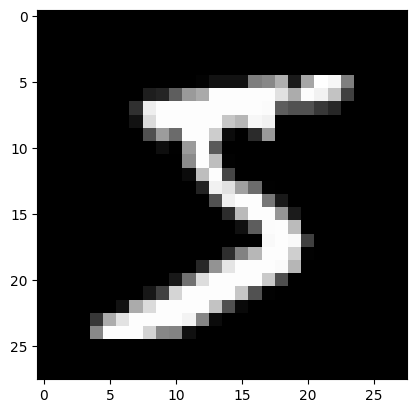

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

Finally, let's create a dataloader to load the images in batches.

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([1, 7, 3, 5, 4, 6, 9, 7, 7, 3, 7, 1, 9, 9, 0, 7, 7, 6, 9, 1, 6, 8, 7, 4,
        6, 2, 1, 5, 2, 6, 7, 7, 0, 6, 2, 1, 6, 3, 6, 1, 1, 6, 3, 2, 5, 7, 9, 3,
        4, 2, 5, 5, 7, 3, 0, 2, 0, 7, 1, 5, 3, 2, 6, 2, 3, 8, 9, 2, 2, 0, 3, 5,
        3, 3, 3, 1, 4, 1, 5, 2, 7, 8, 3, 8, 1, 2, 3, 6, 8, 7, 5, 1, 4, 4, 3, 5,
        9, 4, 9, 3])


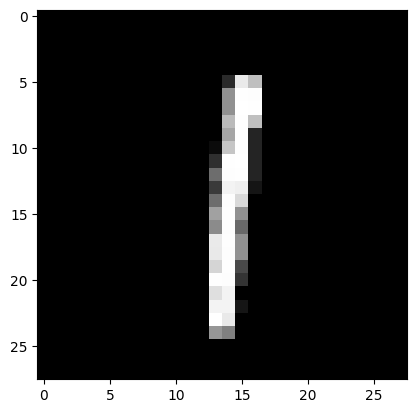

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

In [9]:
%%timeit

for img, label in data_loader:
    continue

15.2 s ± 652 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 1. Discriminator

In [10]:
image_size = 784
hidden_size = 256

In [11]:
import torch.nn as nn

D = nn.Sequential(torch.nn.Linear(image_size, hidden_size),
                  torch.nn.LeakyReLU(),
                  torch.nn.Linear(hidden_size, hidden_size),
                  torch.nn.LeakyReLU(),
                  torch.nn.Linear(hidden_size, 1),
                  torch.nn.Sigmoid()
)

In [12]:
D = D.to(device);

In [13]:
D

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## 2.  Generator

In [14]:
latent_size = 64
hidden_size = image_size // 3
hidden_size

261

In [15]:
G = nn.Sequential(
    torch.nn.Linear(latent_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [16]:
G = G.to(device)

## 3. Training

In [17]:
criterion = torch.nn.BCELoss()
epochs = 40
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
real_label = 1
fake_label = 0
fixed_noise = torch.randn(batch_size, latent_size, device=device)

In [18]:
import torchvision.utils as vutils
from tqdm import tqdm

In [19]:

for epoch in range(epochs):
  print(f"Epoch{epoch}")
  for i, img_batch in enumerate(data_loader):

    #Real Images
    img_batch = img_batch[0]
    img_batch = torch.flatten(img_batch, 1)
    img_batch = img_batch.to(device)
    D.zero_grad()
    labels = torch.full((batch_size,), real_label, dtype=torch.float)
    labels = labels.to(device).reshape(batch_size, 1)
    output_real = D(img_batch)
    err_real = criterion(output_real, labels)
    print(err_real.item())
    err_real.backward()
    avg_confidence_true = output_real.mean().item()
    #Fake Image
    labels.fill_(fake_label)
    noises = torch.randn(batch_size, latent_size, device = device)
    fake_img_batch = G(noises)
    output_fake = D(fake_img_batch.detach())
    err_fake = criterion(output_fake, labels)
    err_fake.backward()
    errD = err_real + err_fake
    optimizerD.step()
    avg_confidence_fake = 1 - output_fake.mean().item()
    # Training G
    G.zero_grad()
    labels.fill_(real_label)  # fake labels are real for generator cost
    output = D(fake_img_batch)
    errG = criterion(output, labels)
    errG.backward()
    avg_confidence_fake_afterstep = 1 - output.mean().item()
    optimizerG.step()
    print(f"Epoch {epoch}, Iter{i}: Loss D: {errD}, LossG: {errD}, confReal: {avg_confidence_true}, confFake1: {avg_confidence_fake}, confFake2: {avg_confidence_fake_afterstep}")
  if i == len(data_loader) - 1:
    print('saving the output')
    fake = G(fixed_noise)
    fake = fake.to("cpu")
    vutils.save_image(fake.detach(),'fake_samples_epoch_%03d.png' % (epoch),normalize=True)

Streaming output truncated to the last 5000 lines.
Epoch 35, Iter504: Loss D: 0.5154178142547607, LossG: 0.5154178142547607, confReal: 0.824705958366394, confFake1: 0.8475886881351471, confFake2: 0.8140448480844498
0.2165343463420868
Epoch 35, Iter505: Loss D: 0.5333779454231262, LossG: 0.5333779454231262, confReal: 0.8760213851928711, confFake1: 0.799900472164154, confFake2: 0.8813034296035767
0.32127630710601807
Epoch 35, Iter506: Loss D: 0.5815776586532593, LossG: 0.5815776586532593, confReal: 0.8078128099441528, confFake1: 0.8242110311985016, confFake2: 0.8655247986316681
0.19855138659477234
Epoch 35, Iter507: Loss D: 0.41751015186309814, LossG: 0.41751015186309814, confReal: 0.8925725221633911, confFake1: 0.841295063495636, confFake2: 0.9149519577622414
0.35101476311683655
Epoch 35, Iter508: Loss D: 0.5039557218551636, LossG: 0.5039557218551636, confReal: 0.8132694959640503, confFake1: 0.8849636763334274, confFake2: 0.8495305627584457
0.20928698778152466
Epoch 35, Iter509: Loss D:

In [20]:
import imageio.v3 as iio
import glob


def get_images():
    idx = torch.randint(low=0, high = 99, size = (1,))
    imgs = []
    for i, im_path in enumerate(glob.glob("*.png")):
        im = iio.imread(im_path)
        img = im[idx]
        imgs += [img]
    return imgs


imgs = get_images()

In [21]:
def plot_img(imgs, epoch):
    img = imgs[epoch]
    img = img.reshape(28, 28, 3)
    plt.imshow(img)

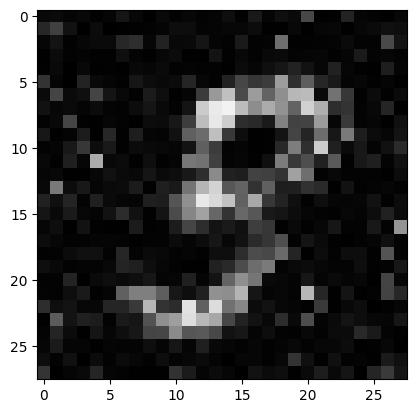

In [26]:
plot_img(imgs, 3)

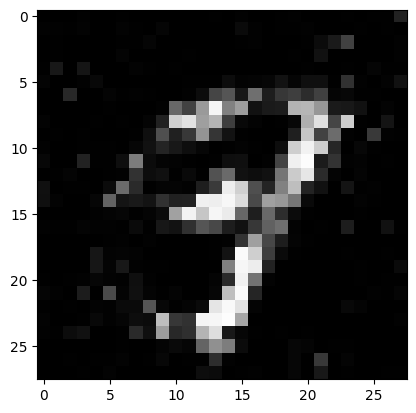

In [23]:
plot_img(imgs, 5)

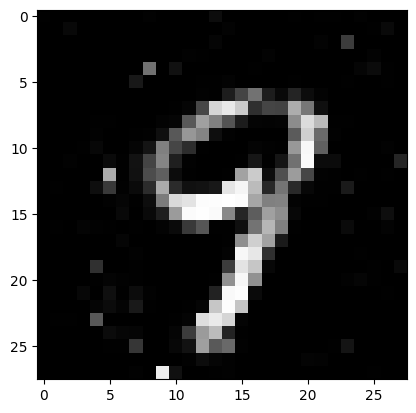

In [24]:
plot_img(imgs, 20)

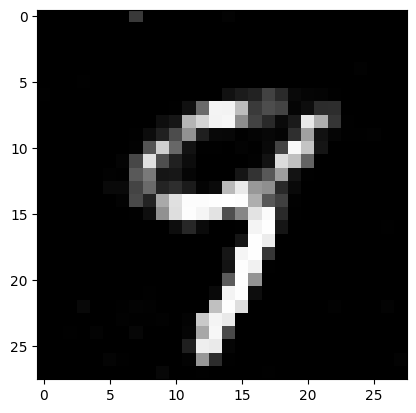

In [25]:
plot_img(imgs, 39)